In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate, scipy.signal
from functions import *

In [2]:
nodes

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.0,0.0,NaN,NaN
1,10,0,NaN,NaN,0.0,-100.0
2,20,0,0.0,0.0,NaN,NaN
3,5,10,NaN,NaN,0.0,0.0
4,15,10,NaN,NaN,0.0,0.0


In [3]:
elements

,start_node,end_node,area,Youngs_modulus,density
0,0,1,0.000002,1.000000e+10,2700
1,1,2,0.000002,1.000000e+10,2700
2,0,3,0.000002,1.000000e+10,2700
3,1,3,0.000002,1.000000e+10,2700
4,1,4,0.000002,1.000000e+10,2700
5,4,2,0.000002,1.000000e+10,2700
6,3,4,0.000002,1.000000e+10,2700


In [4]:
elements[['length', 'stiffness_matrix']] = elements.apply(element_stiffness, axis=1, result_type='expand')
elements['mass_matrix'] = elements.apply(element_mass, axis=1)
elements

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
3,1,3,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
4,1,4,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
5,4,2,0.000002,1.000000e+10,2700,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.030186917696247158, 0.0, 0.0, 0.0], [0.0, ..."
6,3,4,0.000002,1.000000e+10,2700,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.026999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [5]:
K = elements.apply(global_stiffness, axis=1).sum()
M = elements.apply(global_mass, axis=1).sum()

In [6]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition(K, A, B)
MAA, MAB, MBA, MBB = partition(M, A, B)

In [7]:
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA),(PA-np.dot(KAB,UB)))
U[A] = UA
PB = np.dot(KBA,UA)+np.dot(KBB,UB)
P[B] = PB

result = nodes.copy()
result[['displacement_x', 'displacement_y']] = U.reshape(-1,2)
result[['load_x', 'load_y']] = P.reshape(-1,2)
result

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.000000e+00,0.000000,25.0,50.0
1,10,0,3.517113e-19,-0.082377,0.0,-100.0
2,20,0,0.000000e+00,0.000000,-25.0,50.0
3,5,10,1.250000e-02,-0.041189,0.0,0.0
4,15,10,-1.250000e-02,-0.041189,0.0,0.0


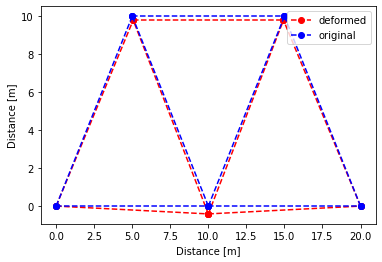

In [8]:
factor = 5
result['deformed_x'] = result['coordinate_x'] + factor*result['displacement_x']
result['deformed_y'] = result['coordinate_y'] + factor*result['displacement_y']

connectpoints(result['deformed_x'], result['deformed_y'],0,1,True,True)
connectpoints(result['deformed_x'], result['deformed_y'],1,2)
connectpoints(result['deformed_x'], result['deformed_y'],0,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,3)
connectpoints(result['deformed_x'], result['deformed_y'],1,4)
connectpoints(result['deformed_x'], result['deformed_y'],2,4)
connectpoints(result['deformed_x'], result['deformed_y'],3,4)

connectpoints(result['coordinate_x'], result['coordinate_y'],0,1,False,True)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,2,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],0,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,3,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],1,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],2,4,False)
connectpoints(result['coordinate_x'], result['coordinate_y'],3,4,False)

plt.xlabel("Distance [m]")
plt.ylabel("Distance [m]")

plt.legend()
plt.show()

In [9]:
frequencies, modes = modal_analysis(MAA, KAA)

In [10]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), a)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

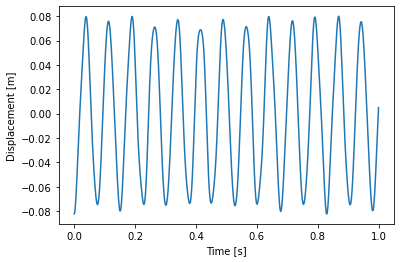

In [11]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [12]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), d)

d, d_dot, v, v_dot = Alpha(MAA, KAA, d, d_dot, v, v_dot, dt, t)

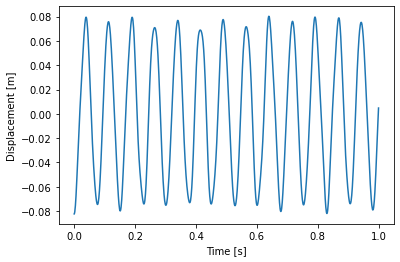

In [13]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [14]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta(MAA, KAA, T_range, x_0)

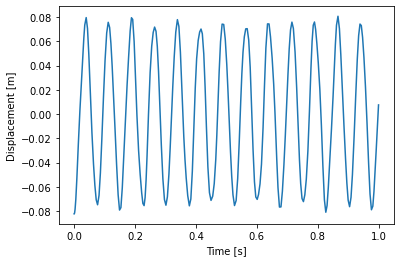

In [15]:
plt.plot(time, x[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

Text(0, 0.5, 'Displacement [m]')

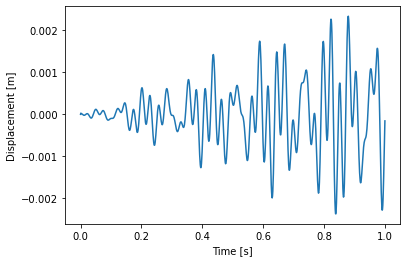

In [16]:
plt.plot(np.linspace(0, T*deltaT, T), d[1,:]-a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [17]:
mse = 0
for i in range(len(a[1,:])):
    mse += (a[1,i]-d[1,i])**2
print(np.sqrt(mse))    

0.02452218099352729


In [18]:
CAA, damping_factors = damping_factors(frequencies, frequencies[0], frequencies[1], 0.05, 0.05, MAA, KAA)

In [19]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, a_dot)-np.dot(KAA, a))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta_damping(MAA, CAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

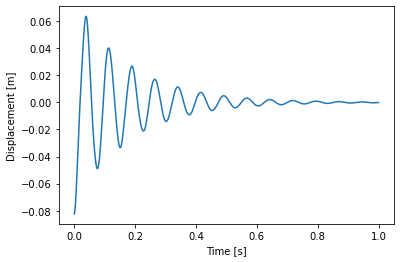

In [20]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [21]:
dt = 0.001
t = 1000

d = np.zeros((len(UA),1))
d[:,0] = np.transpose(UA)
d_dot = np.zeros((len(UA),1))
v = np.zeros((len(UA),1))
v_dot = np.dot(np.linalg.inv(MAA), -np.dot(CAA, d_dot)-np.dot(KAA, d))

d, d_dot, v, v_dot = Alpha_damping(MAA, CAA, KAA, d, d_dot, v, v_dot, dt, t)

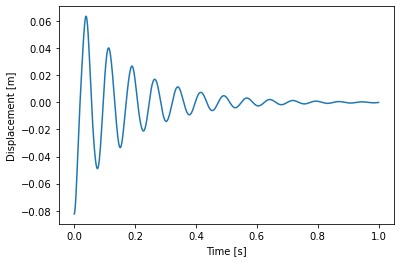

In [22]:
plt.plot(np.linspace(0, t*dt, t), d[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

In [23]:
T_range = [0,1]
x_0 = np.transpose(np.hstack((UA,np.zeros(len(UA)))))
time, x = Runge_Kutta_damping(MAA, CAA, KAA, T_range, x_0)

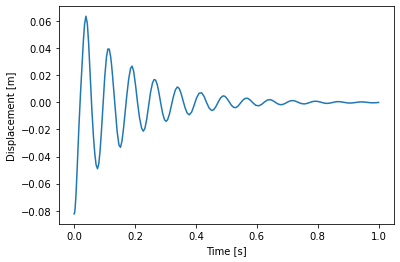

In [24]:
plt.plot(time, x[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")
plt.show()

Text(0, 0.5, 'Displacement [m]')

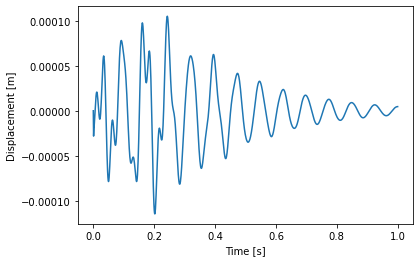

In [25]:
plt.plot(np.linspace(0, T*deltaT, T), a[1,:]-d[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [26]:
mse = 0
for i in range(len(a[1,:])):
    mse += (a[1,i]-d[1,i])**2
print(np.sqrt(mse))  

0.0011102652714073257


In [27]:
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)

Text(0, 0.5, 'Displacement [m]')

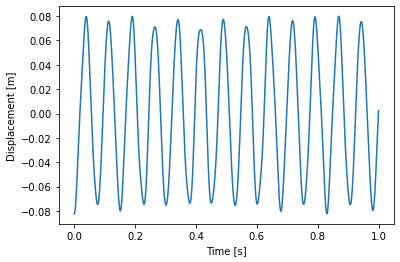

In [28]:
a = np.zeros((3*len(UA),1))
a[0:6,0] = np.transpose(UA)
for i in range(T-1):
  a_new = np.dot(A, a[:,i])
  a = np.append(a, a_new.reshape(3*len(UA),1), axis=1)

plt.plot(np.linspace(0, T*deltaT, T), a[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [29]:
deltaT = 0.001
T = 1000

a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = -np.dot(np.dot(np.linalg.inv(MAA), KAA), a)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)

In [30]:
data = generate_pseudo_data(a, T, 0.2)

Text(0, 0.5, 'Displacement [m]')

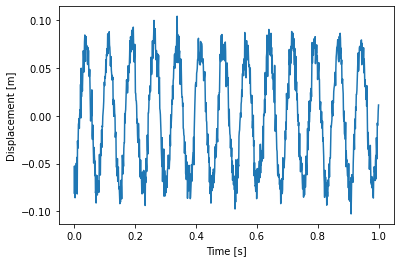

In [31]:
plt.plot(np.linspace(0, T*deltaT, T), data[1,:])
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

In [32]:
H = observe_displacements(A)

In [33]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x, energy = Kalman_filter(A, B, H, x, f, data, 1, 1, 1, T)

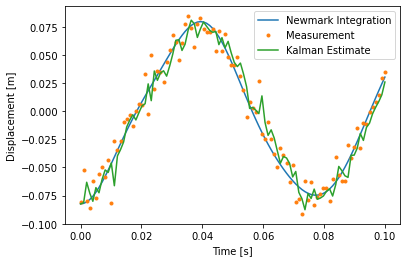

In [34]:
scale = 0.1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[1,:int(T*scale)], label='Newmark Integration')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[1,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[1,:int(T*scale)], label='Kalman Estimate')
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

In [35]:
elements2[['length', 'stiffness_matrix']] = elements2.apply(element_stiffness, axis=1, result_type='expand')
elements2['mass_matrix'] = elements2.apply(element_mass, axis=1)
elements2

,start_node,end_node,area,Youngs_modulus,density,length,stiffness_matrix,mass_matrix
0,0,1,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
1,1,2,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."
2,0,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
3,1,3,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
4,1,4,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, 715.5417527999326, -357.7...","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
5,4,2,0.000002,1.000000e+10,3500,11.18034,"[[357.7708763999663, -715.5417527999326, -357....","[[0.03913118960624632, 0.0, 0.0, 0.0], [0.0, 0..."
6,3,4,0.000002,1.000000e+10,3500,10.00000,"[[2000.0, 0.0, -2000.0, -0.0], [0.0, 0.0, -0.0...","[[0.034999999999999996, 0.0, 0.0, 0.0], [0.0, ..."


In [36]:
K2 = elements2.apply(global_stiffness, axis=1).sum()
M2 = elements2.apply(global_mass, axis=1).sum()

In [37]:
U = nodes[['displacement_x', 'displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x', 'load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)
KAA2, KAB2, KBA2, KBB2 = partition(K2, A, B)
MAA2, MAB2, MBA2, MBB2 = partition(M2, A, B)
UB = U[B]
PA = P[A]
UA = np.dot(np.linalg.inv(KAA2),(PA-np.dot(KAB2,UB)))
U[A] = UA
PB = np.dot(KBA2,UA)+np.dot(KBB2,UB)
P[B] = PB

In [38]:
A = transition_matrix_Newmark_Beta(MAA, KAA, deltaT)
A2 = transition_matrix_Newmark_Beta(MAA2, KAA2, deltaT)
B = force_matrix_Newmark_Beta(MAA, KAA, deltaT)
B2 = force_matrix_Newmark_Beta(MAA2, KAA2, deltaT)

In [39]:
a2 = np.zeros((len(UA),1))
a2[:,0] = np.transpose(UA)
a2_dot = np.zeros((len(UA),1))
a2_ddot = np.dot(np.linalg.inv(MAA2), np.dot(KAA2, a2))
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)

a2, a2_dot, a2_ddot = Newmark_Beta(MAA2, KAA2, f, a2, a2_dot, a2_ddot, deltaT, T)
data2 = generate_pseudo_data(a2, T, 0.2)

In [40]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
f = np.zeros((len(PA),T))
f[:,0] = np.transpose(PA)
x, energy = Kalman_filter(A, B, H, x, f, data2, 1, 0.2*np.std(a), 0.05*np.mean(np.abs(a)), T)

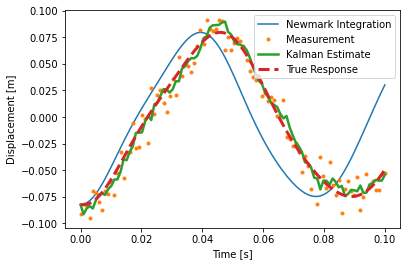

In [41]:
scale = 0.1
index = 1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[index,:int(T*scale)], label='Newmark Integration')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data2[index,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[index,:int(T*scale)], label='Kalman Estimate', linewidth=2.5)
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a2[index,:int(T*scale)], '--', label='True Response', linewidth=3.0)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

In [64]:
def Kalman_filter_aug(A, B, H, x, force_func, y, sigma_0, sigma_r, sigma_q, sigma_epsilon, T):
  Q = sigma_q*np.identity(np.shape(A)[0])
  R = sigma_r*np.identity(np.shape(y)[0])
  
  P = [sigma_0*np.identity(np.shape(A)[0])]

  energy = 0

  for i in range(T-1):
    f = force_func(x[-1,i],T)
    x_predict = np.dot(A, x[:,i]) + np.dot(B, f[:,i+1])
    P_predict = np.dot(A, np.dot(P[i], np.transpose(A))) + Q
    V = y[:,i] - np.dot(H, x_predict)
    S = np.dot(H, np.dot(P_predict, np.transpose(H))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(S, np.transpose(K)))
    x_estimate[-1] += np.random.normal(0, sigma_epsilon)

    x = np.append(x, x_estimate.reshape(np.shape(A)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, energy

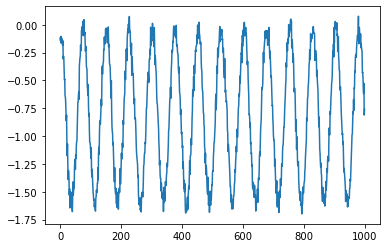

In [65]:
T = 1000
f = constant_force(-500, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
data = generate_pseudo_data(a, T, 0.1)
plt.plot(data[1,:])

In [70]:
param = [-400]
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
A_aug, B_aug, H_aug = aug_lin_model(A, B, H, x, param)

In [71]:
aug_state = np.vstack((x,param))

In [72]:
aug_state, energy = Kalman_filter_aug(A_aug, B_aug, H_aug, aug_state, constant_force, data, 1, 0.01, 1000, 2, T)

-365.5597439759442


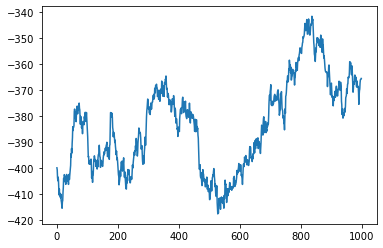

In [73]:
plt.plot(aug_state[18,:])
# plt.plot(data[1,:])
print(aug_state[-1,-1])

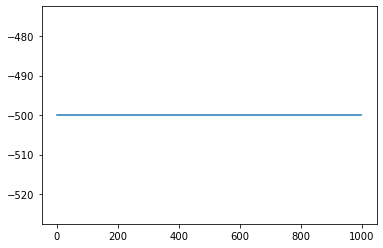

In [48]:
f = constant_force(-500, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(f[1,:])

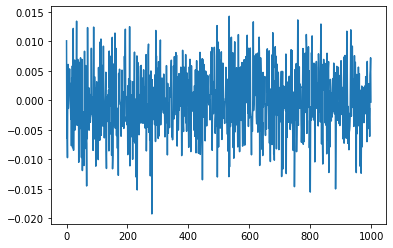

In [49]:
data = generate_pseudo_data(a, T, 0.01)
plt.plot(data[1,:]-a[1,:])

In [50]:
sigma_r = 0.01*np.std(a)
sigma_q = np.mean(np.abs(a))
print(sigma_r)
print(sigma_q)

0.005153211669878476
0.6515587573799043


100%|██████████| 999/999 [02:10<00:00,  7.63it/s]

-666.205153293762
0.071


Text(0, 0.5, 'Parameter Posterior')

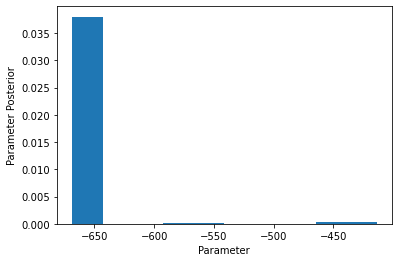

In [51]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
N = 1000
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, sigma_r, 0*sigma_q, -400, 100, 0.2, T, N, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

-666.205153293762


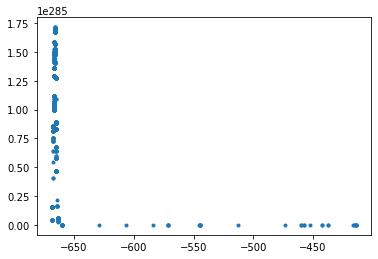

In [52]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

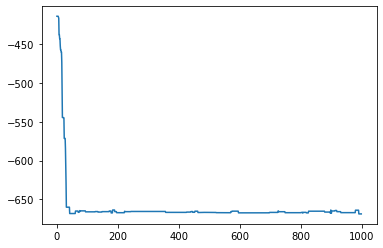

In [53]:
plt.plot(param)

In [54]:
x_MC = np.zeros(N)
for i in range(N):
    x_MC += X[i][1,:]
x_MC = x_MC/N

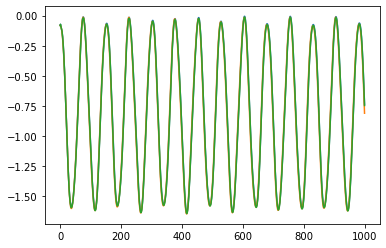

In [55]:
plt.plot(x_MC)
plt.plot(a[1,:])
plt.plot(X[index][1,:])

In [56]:
diff = 0
for i in range(len(a[1,:])):
    diff += (x_MC[i]-a[1,i])**2
print(diff)

1.3980301793878982


In [57]:
diff = 0
for i in range(len(a[1,:])):
    diff += (X[index][1,i]-a[1,i])**2
print(diff)

1.362931084149943


In [58]:
factors = np.linspace(0,1000,20)
MAP = []
N = 100
for factor in factors:
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, sigma_r, factor*sigma_q, -400, 100, 0.2, T, N, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:12<00:00,  7.77it/s]


In [59]:
for i in range(len(MAP)):
    MAP[i] = -MAP[i]/500

Text(0, 0.5, 'MAP parameter estimate')

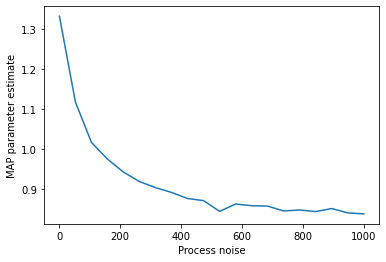

In [60]:
plt.plot(factors, MAP)
plt.xlabel("Process noise")
plt.ylabel("MAP parameter estimate")

In [61]:
factors = np.linspace(0,1,20)
MAP = []
for factor in factors:
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, sigma_r, factor*sigma_q, -400, 100, 0.2, T, N, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:12<00:00,  7.97it/s]


In [62]:
for i in range(len(MAP)):
    MAP[i] = -MAP[i]/500

Text(0, 0.5, 'MAP parameter estimate')

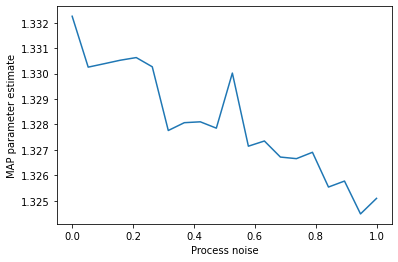

In [63]:
plt.plot(factors, MAP)
plt.xlabel("Process noise")
plt.ylabel("MAP parameter estimate")

In [64]:
SNR = np.linspace(10, 100, 20)
MAP = []
for i in range(len(SNR)):
    data = generate_pseudo_data(a, T, 1/SNR[i])
    sigma_r = 1/SNR[i]*np.std(a)
    sigma_q = np.mean(np.abs(a))
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, constant_force, data, 1, sigma_r, 0*sigma_q, -400, 100, 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:12<00:00,  8.19it/s]


In [65]:
for i in range(len(MAP)):
    MAP[i] = -MAP[i]/500

Text(0, 0.5, 'MAP parameter estimate')

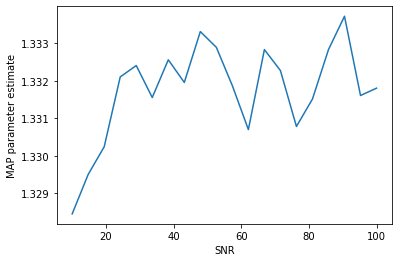

In [66]:
plt.plot(SNR, MAP)
plt.xlabel("SNR")
plt.ylabel("MAP parameter estimate")

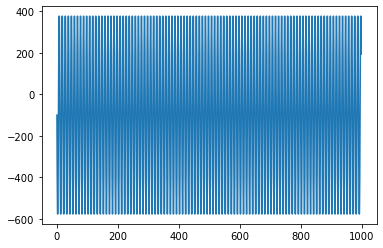

In [67]:
f = sinusoidal_force(-500, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(f[1,:])

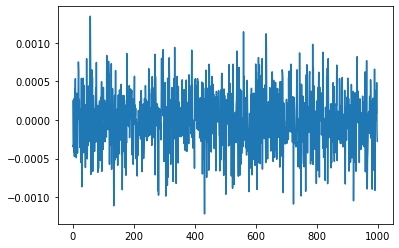

In [68]:
data = generate_pseudo_data(a, T, 0.01)
plt.plot(data[1,:]-a[1,:])

In [69]:
sigma_r = 0.01*np.std(a)
sigma_q = np.mean(np.abs(a))
print(sigma_r)
print(sigma_q)

0.00038780331075354625
0.03239051824923137


100%|██████████| 999/999 [02:09<00:00,  7.73it/s]

-515.1828494502136
0.849


Text(0, 0.5, 'Parameter Posterior')

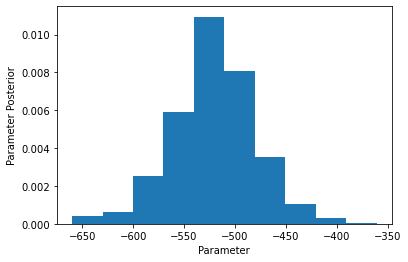

In [70]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
N = 1000
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, sinusoidal_force, data, 1, sigma_r, 0*sigma_q, -400, 100, 0.2, T, N, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

-515.1828494502136


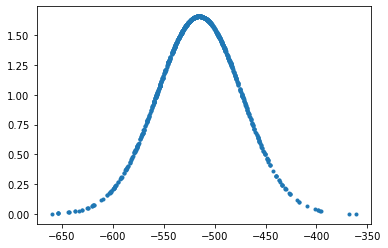

In [71]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

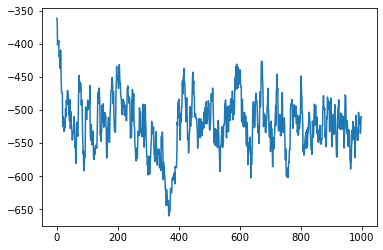

In [72]:
plt.plot(param)

In [73]:
x_MC = np.zeros(N)
for i in range(N):
    x_MC += X[i][1,:]
x_MC = x_MC/N

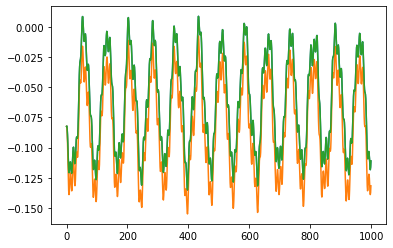

In [74]:
plt.plot(x_MC)
plt.plot(a[1,:])
plt.plot(X[index][1,:])

In [75]:
diff = 0
for i in range(len(a[1,:])):
    diff += (x_MC[i]-a[1,i])**2
print(diff)

0.4345571750971199


In [76]:
diff = 0
for i in range(len(a[1,:])):
    diff += (X[index][1,i]-a[1,i])**2
print(diff)

0.4348629782996278


In [77]:
factors = np.linspace(0,100,20)
MAP = []
for factor in factors:
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, sinusoidal_force, data, 1, sigma_r, factor*sigma_q, -400, 100, 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:13<00:00,  7.55it/s]


In [78]:
for i in range(len(MAP)):
    MAP[i] = -MAP[i]/500

Text(0, 0.5, 'MAP parameter estimate')

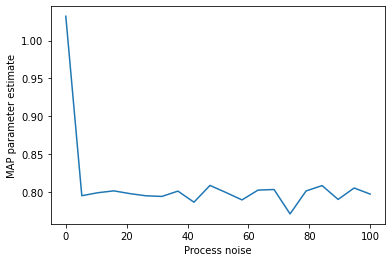

In [79]:
plt.plot(factors, MAP)
plt.xlabel("Process noise")
plt.ylabel("MAP parameter estimate")

In [80]:
factors = np.linspace(0,1,20)
MAP = []
for factor in factors:
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, sinusoidal_force, data, 1, sigma_r, factor*sigma_q, -400, 100, 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:12<00:00,  7.83it/s]


In [81]:
for i in range(len(MAP)):
    MAP[i] = -MAP[i]/500

Text(0, 0.5, 'MAP parameter estimate')

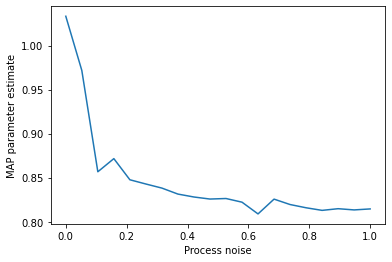

In [82]:
plt.plot(factors, MAP)
plt.xlabel("Process noise")
plt.ylabel("MAP parameter estimate")

In [83]:
SNR = np.linspace(10, 100, 20)
MAP = []
for i in range(len(SNR)):
    data = generate_pseudo_data(a, T, 1/SNR[i])
    sigma_r = 1/SNR[i]*np.std(a)
    sigma_q = np.mean(np.abs(a))
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, sinusoidal_force, data, 1, sigma_r, 0*sigma_q, -400, 100, 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:12<00:00,  7.64it/s]


In [84]:
for i in range(len(MAP)):
    MAP[i] = -MAP[i]/500

Text(0, 0.5, 'MAP parameter estimate')

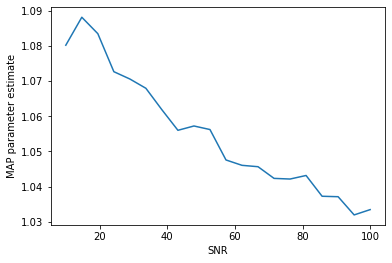

In [85]:
plt.plot(SNR, MAP)
plt.xlabel("SNR")
plt.ylabel("MAP parameter estimate")

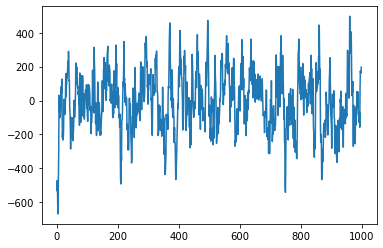

In [86]:
f = AR_1(0.8, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(f[1,:])

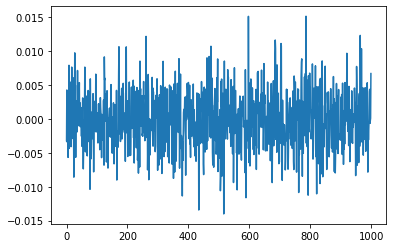

In [87]:
data = generate_pseudo_data(a, T, 0.01)
plt.plot(data[1,:]-a[1,:])

In [88]:
sigma_r = 0.01*np.std(a)
sigma_q = np.mean(np.abs(a))
print(sigma_r)
print(sigma_q)

0.004131638638262992
0.3240885695473685


100%|██████████| 999/999 [02:20<00:00,  7.11it/s]


0.5880063888652857
0.003


Text(0, 0.5, 'Parameter Posterior')

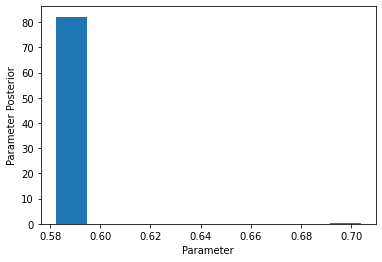

In [89]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
N = 1000
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, AR_1, data, 1, sigma_r, 0*sigma_q, 0.6, 0.6, 0.2, T, N, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)
plt.hist(param, density=True)
plt.xlabel("Parameter")
plt.ylabel("Parameter Posterior")

0.5880063888652857


<ipython-input-90-0c7eda03b715>:4: RuntimeWarning: overflow encountered in exp
  posterior.append(np.exp(-energy_list[i]+scale))


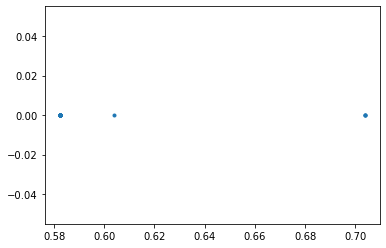

In [90]:
posterior = []
scale = np.mean(energy_list)
for i in range(len(energy_list)):
    posterior.append(np.exp(-energy_list[i]+scale))
plt.plot(param, posterior, '.')
print(param[np.argmax(posterior)])

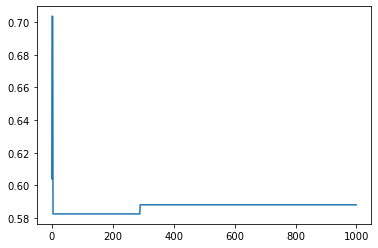

In [91]:
plt.plot(param)

In [92]:
x_MC = np.zeros(N)
for i in range(N):
    x_MC += X[i][1,:]
x_MC = x_MC/N

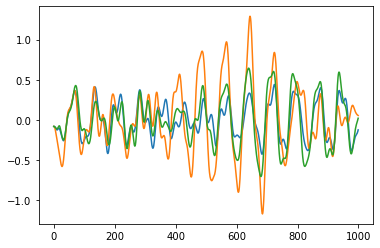

In [93]:
plt.plot(x_MC)
plt.plot(a[1,:])
plt.plot(X[index][1,:])

In [94]:
diff = 0
for i in range(len(a[1,:])):
    diff += (x_MC[i]-a[1,i])**2
print(diff)

118.85320504597078


In [95]:
diff = 0
for i in range(len(a[1,:])):
    diff += (X[index][1,i]-a[1,i])**2
print(diff)

89.66936558596694


In [96]:
factors = np.linspace(0,100,20)
MAP = []
for factor in factors:
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, AR_1, data, 1, sigma_r, factor*sigma_q, 0.6, 0.6, 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

  0%|          | 0/99 [00:00<?, ?it/s]d:\Karol\IIB_project\functions.py:334: RuntimeWarning: invalid value encountered in double_scalars
  acceptance = min(0, (energy_list[j-1]-phi))
100%|██████████| 99/99 [00:14<00:00,  6.83it/s]
d:\Karol\IIB_project\functions.py:362: RuntimeWarning: overflow encountered in multiply
  f_new = param*force[:,i-1]
  6%|▌         | 6/99 [00:00<00:12,  7.19it/s]d:\Karol\IIB_project\functions.py:274: RuntimeWarning: overflow encountered in add
  x_predict = np.dot(A, x[:,i]) + np.dot(B, f[:,i+1])
100%|██████████| 99/99 [00:14<00:00,  6.98it/s]


In [97]:
for i in range(len(MAP)):
    MAP[i] = MAP[i]/0.8

Text(0, 0.5, 'MAP parameter estimate')

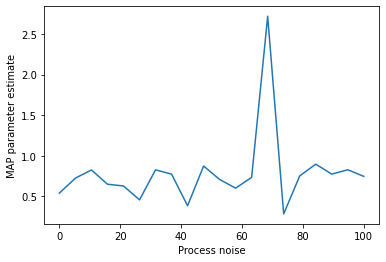

In [98]:
plt.plot(factors, MAP)
plt.xlabel("Process noise")
plt.ylabel("MAP parameter estimate")

In [99]:
factors = np.linspace(0,1,20)
MAP = []
for factor in factors:
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, AR_1, data, 1, sigma_r, factor*sigma_q, 0.6, 0.6, 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

  0%|          | 0/99 [00:00<?, ?it/s]d:\Karol\IIB_project\functions.py:334: RuntimeWarning: invalid value encountered in double_scalars
  acceptance = min(0, (energy_list[j-1]-phi))
100%|██████████| 99/99 [00:14<00:00,  7.04it/s]


In [100]:
for i in range(len(MAP)):
    MAP[i] = MAP[i]/0.8

Text(0, 0.5, 'MAP parameter estimate')

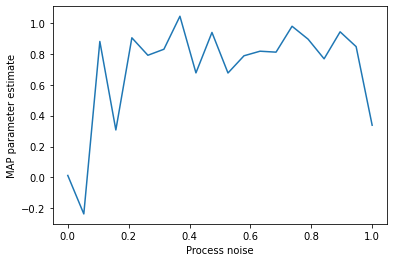

In [101]:
plt.plot(factors, MAP)
plt.xlabel("Process noise")
plt.ylabel("MAP parameter estimate")

In [102]:
SNR = np.linspace(10, 100, 20)
MAP = []
for i in range(len(SNR)):
    data = generate_pseudo_data(a, T, 1/SNR[i])
    sigma_r = 1/SNR[i]*np.std(a)
    sigma_q = np.mean(np.abs(a))
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, AR_1, data, 1, sigma_r, 0*sigma_q, 0.6, 0.6, 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

  0%|          | 0/99 [00:00<?, ?it/s]d:\Karol\IIB_project\functions.py:362: RuntimeWarning: overflow encountered in multiply
  f_new = param*force[:,i-1]
  4%|▍         | 4/99 [00:00<00:13,  7.31it/s]d:\Karol\IIB_project\functions.py:334: RuntimeWarning: invalid value encountered in double_scalars
  acceptance = min(0, (energy_list[j-1]-phi))
 35%|███▌      | 35/99 [00:04<00:08,  7.33it/s]d:\Karol\IIB_project\functions.py:274: RuntimeWarning: overflow encountered in add
  x_predict = np.dot(A, x[:,i]) + np.dot(B, f[:,i+1])
100%|██████████| 99/99 [00:14<00:00,  7.06it/s]


In [103]:
for i in range(len(MAP)):
    MAP[i] = MAP[i]/0.8

Text(0, 0.5, 'MAP parameter estimate')

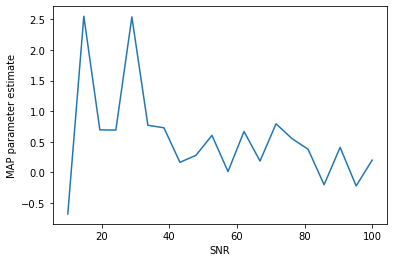

In [104]:
plt.plot(SNR, MAP)
plt.xlabel("SNR")
plt.ylabel("MAP parameter estimate")

In [105]:
# autocorr = scipy.signal.correlate(X[index][1,:],X[index][1,:])
# autocorr_true = scipy.signal.correlate(a[1,:],a[1,:])
# plt.plot(autocorr_true-autocorr)
# plt.plot(autocorr_true)

In [106]:
# def true_autocorr(param, T):
#     scale = 100/(1-param**2)
#     autocorr = []
#     for i in range(-T,T):
#         autocorr.append(scale*param**np.abs(i))
#     return autocorr       

In [107]:
# force = AR_1(mean_MAP,T)
# force_true = AR_1(0.9,T)
# force_autocorr = scipy.signal.correlate(force[1,:],force[1,:])
# force_autocorr_true = scipy.signal.correlate(force_true[1,:],force_true[1,:])
# true_autocor = true_autocorr(0.9,T)
# # plt.plot(true_autocor, ',')
# plt.plot(force_autocorr, ',')
# plt.plot(force_autocorr_true, ',')

In [42]:
wind = open('Wind.txt', 'r')
windString = wind.read()
windList = windString.split()
for i in range(len(windList)):
    windList[i] = float(windList[i])
wind = np.reshape(windList, (int(len(windList)/5), 5)).T

In [43]:
def wind_force(param, T):
    f = []
    f.append(np.zeros(T))
    f.append(0.5*1.2*np.mean(wind[1,:T])*20*param[0]+0.5*1.2*(wind[1,:T]-np.mean(wind[1,:T]))*20*param[1])
    f.append(np.zeros(T))
    f.append(0.5*1.2*np.mean(wind[3,:T])*20*param[0]+0.5*1.2*(wind[3,:T]-np.mean(wind[3,:T]))*20*param[1])
    f.append(np.zeros(T))
    f.append(0.5*1.2*np.mean(wind[4,:T])*20*param[0]+0.5*1.2*(wind[4,:T]-np.mean(wind[4,:T]))*20*param[1])
    return np.array(f)

In [44]:
def Newmark_Beta(M, K, f, a, a_dot, a_ddot, deltaT, T, beta=1/4, gamma=1/2):
  M_new = 1/(beta*deltaT*deltaT)*M+K
  for i in range(T-1):
    expression = 1/(beta*deltaT*deltaT)*a[:,i]+1/(beta*deltaT)*a_dot[:,i]+1/(2*beta)*a_ddot[:,i]-a_ddot[:,i]
    F_new = np.dot(M, expression) + f[:,i]
    a_new = np.dot(np.linalg.inv(M_new), F_new)
    a = np.append(a, a_new.reshape(np.shape(M)[0],1), axis=1)
    a_ddot_new = 1/(beta*deltaT*deltaT)*(a[:,i+1]-a[:,i])-1/(beta*deltaT)*a_dot[:,i]-1/(2*beta)*a_ddot[:,i]+a_ddot[:,i]
    a_ddot = np.append(a_ddot, a_ddot_new.reshape(np.shape(M)[0],1), axis=1)
    a_dot_new = a_dot[:,i]+deltaT*(1-gamma)*a_ddot[:,i]+deltaT*gamma*a_ddot_new
    a_dot = np.append(a_dot, a_dot_new.reshape(np.shape(M)[0],1), axis=1)
  return a, a_dot, a_ddot

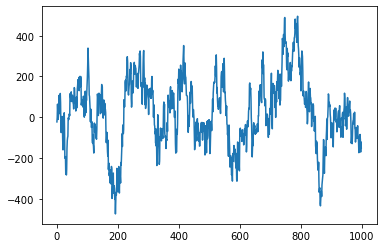

In [45]:
a = np.zeros((len(UA),1))
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
f = wind_force([0.05, 4.3], 1000)
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
plt.plot(f[1,:])

0.00531091740179197
0.3401775129781284


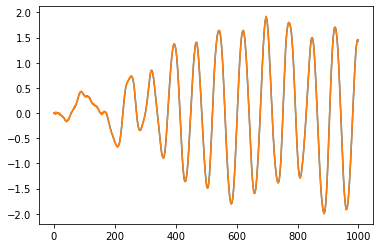

In [46]:
data = generate_pseudo_data(a, T, 0.01)
plt.plot(a[1,:])
plt.plot(data[1,:])
sigma_r = 0.01*np.std(a)
sigma_q = np.mean(np.abs(a))
print(sigma_r)
print(sigma_q)

In [47]:
H = observe_displacements(A)

In [48]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
x, energy = Kalman_filter(A, B, H, x, f, data, 1, sigma_r, sigma_q, T)

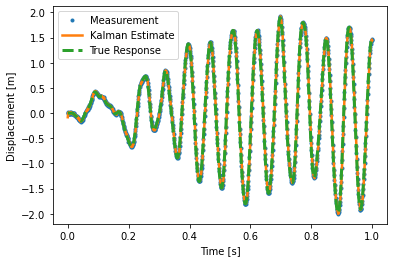

In [49]:
scale = 1
index = 1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[index,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[index,:int(T*scale)], label='Kalman Estimate', linewidth=2.5)
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a[index,:int(T*scale)], '--', label='True Response', linewidth=3.0)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

In [87]:
def Metropolis_Hastings(A, B, H, x, force_func, y, sigma_0, sigma_r, sigma_q, prior_mean, prior_var, beta, T, N, method):
  x_init = x
  X = []
  acc = 0

  param = []
  param.append(np.random.multivariate_normal(prior_mean, prior_var))

  energy_list = []

  f = force_func(param[0], T)
  phi = 0.5*np.log((2*np.pi)**len(prior_mean)*np.linalg.det(prior_var))+0.5*(param[0]-prior_mean).T@np.linalg.inv(prior_var)@(param[0]-prior_mean)
  x, energy = Kalman_filter(A, B, H, x_init, f, y, sigma_0, sigma_r, sigma_q, T)
  X.append(x)
  phi += energy
  energy_list.append(phi)
  for j in tqdm(range(1,N)):
    if method == 'pcn':
      proposal = np.sqrt(1-beta**2)*param[j-1] + beta*np.random.multivariate_normal([0, 0], prior_var)
      phi = 0
    elif method == 'grw':
      proposal = param[j-1] + beta*np.random.multivariate_normal([0, 0], prior_var)
      phi = 0.5*np.log((2*np.pi)**len(prior_mean)*np.linalg.det(prior_var))+0.5*(proposal-prior_mean).T@np.linalg.inv(prior_var)@(proposal-prior_mean)
    f = force_func(proposal, T)
    x, energy = Kalman_filter(A, B, H, x_init, f, y, sigma_0, sigma_r, sigma_q, T)
    X.append(x)
    phi += energy

    acceptance = min(0, (energy_list[j-1]-phi))
    uniform = np.random.uniform(0,1)
    if np.log(uniform) <= acceptance:
      acc += 1
      param.append(proposal)
      energy_list.append(phi)
    else:
      param.append(param[j-1])
      energy_list.append(energy_list[j-1])
  return param, energy_list, X, acc/N

In [50]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, wind_force, data, 1, sigma_r, 1*sigma_q, [0, 4], [[0.001, 0], [0, 0.1]], 0.2, T, 1000, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)

ValueError: operands could not be broadcast together with shapes (1000,) (2,) 

In [223]:
x = []
y = []
for i in range(len(param)):
    x.append(param[i][0])
    y.append(param[i][1])

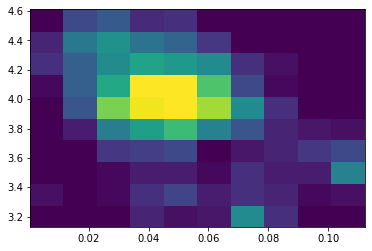

In [224]:
plt.hist2d(x, y)
plt.show()

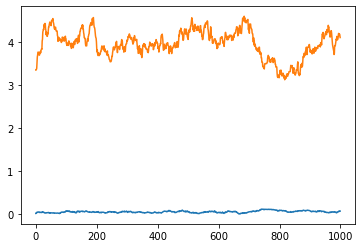

In [225]:
plt.plot(param)

43.44567958084229
1063.4101978339281


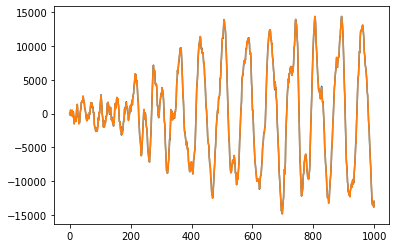

In [50]:
data = generate_pseudo_data(a_ddot, T, 0.01)
plt.plot(a_ddot[1,:])
plt.plot(data[1,:])
sigma_r = 0.01*np.std(a_ddot)
sigma_q = np.mean(np.abs([a_ddot,a_dot,a]))
print(sigma_r)
print(sigma_q)

In [51]:
H = observe_accelerations(A)

In [52]:
x = np.zeros((3*len(UA),1))
x, energy = Kalman_filter(A, B, H, x, f, data, 1, sigma_r, sigma_q, T)

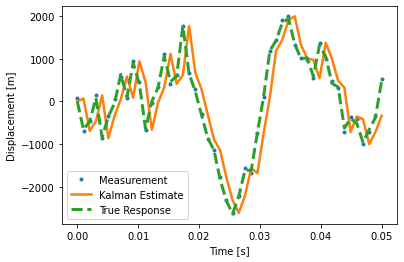

In [53]:
scale = 0.05
index = -1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[index,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x[index,:int(T*scale)], label='Kalman Estimate', linewidth=2.5)
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a_ddot[index,:int(T*scale)], '--', label='True Response', linewidth=3.0)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

In [54]:
A12 = np.zeros((len(x),len(f)))
A21 = np.transpose(A12)
A22 = np.identity(len(f))
A1 = np.hstack((A,B))
A2 = np.hstack((A21,A22))
A_aug = np.vstack((A1,A2))

H2 = np.zeros((np.shape(H)[0],len(f)))
H_aug = np.hstack((H,H2))

In [456]:
def Kalman_filter_aug(A, A_aug, H_aug, x, y, sigma_0, sigma_r, sigma_q, sigma_f, T):
  Q11 = sigma_q*np.identity(np.shape(A)[0])
  Q12 = np.zeros((18,6))
  Q21 = Q12.T
  Q22 = np.zeros((6,6))
  Q22[0,0] = sigma_f[0]
  Q22[1,1] = sigma_f[1]
  Q22[2,2] = sigma_f[2]
  Q22[3,3] = sigma_f[3]
  Q22[4,4] = sigma_f[4]
  Q22[5,5] = sigma_f[5]
  Q1 = np.hstack((Q11,Q12))
  Q2 = np.hstack((Q21,Q22))
  Q = np.vstack((Q1,Q2))
  R = sigma_r*np.identity(np.shape(y)[0])
  
  P = [sigma_0*np.identity(np.shape(A_aug)[0])]

  energy = 0

  for i in range(T-1):
    x_predict = np.dot(A_aug, x[:,i])
    P_predict = np.dot(A_aug, np.dot(P[i], np.transpose(A_aug))) + Q
    V = y[:,i] - np.dot(H_aug, x_predict)
    S = np.dot(H_aug, np.dot(P_predict, np.transpose(H_aug))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H_aug), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(H_aug, P_predict))

    x = np.append(x, x_estimate.reshape(np.shape(A_aug)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, energy


In [522]:
x = np.zeros((3*len(UA),1))
x_aug = np.vstack((x,PA.reshape(6,1)))
x_aug, energy = Kalman_filter_aug(A, A_aug, H_aug, x_aug, data, 0, 1*sigma_r, 0*sigma_q, sigma_f_opt, T)

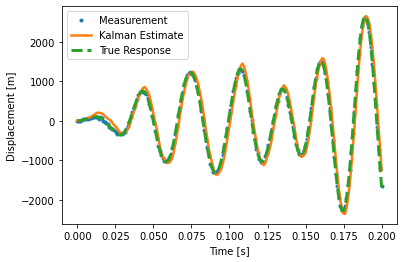

In [523]:
scale = 0.2
index = -1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[0,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x_aug[12,:int(T*scale)], label='Kalman Estimate', linewidth=2.5)
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a_ddot[0,:int(T*scale)], '--', label='True Response', linewidth=3.0)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

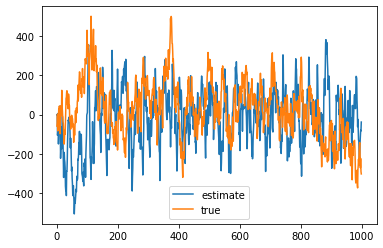

In [531]:
plt.plot(x_aug[23,:], label='estimate')
plt.plot(wind_force([0.05, 4.3], 1000)[5,:], label='true')
plt.legend()

In [519]:
errors = []
smoothings = []
sigma_fs = []
for sigma_f_0 in tqdm(np.logspace(-3,1,5)):
    for sigma_f_1 in np.logspace(-3,1,5):
        for sigma_f_2 in np.logspace(-3,1,5):
            for sigma_f_3 in np.logspace(-3,1,5):
                for sigma_f_4 in np.logspace(-3,1,5):
                    for sigma_f_5 in np.logspace(-3,1,5):
                        sigma_f = [sigma_f_0,sigma_f_1,sigma_f_2,sigma_f_3,sigma_f_4,sigma_f_5]
                        x = np.zeros((3*len(UA),1))
                        x_aug = np.vstack((x,PA.reshape(6,1)))
                        x_aug, energy = Kalman_filter_aug(A, A_aug, H_aug, x_aug, data, 0, 1*sigma_r, 0*sigma_q, sigma_f, T)
                        error = np.linalg.norm(data-H_aug@x_aug)**2
                        smoothing = np.linalg.norm(x_aug[18:23,:])**2
                        errors.append(error)
                        smoothings.append(smoothing)
                        sigma_fs.append(sigma_f)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [1:10:33<00:00, 846.62s/it]


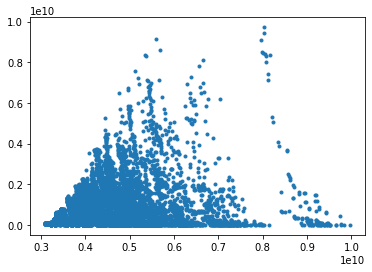

In [520]:
plt.plot(errors,smoothings,'.')

In [521]:
errors_and_smoothings = []
for i in range(len(errors)):
    errors_and_smoothings.append(errors[i]+smoothings[i])
index = np.argmin(errors_and_smoothings)
sigma_f_opt = sigma_fs[index]

In [427]:
def Kalman_filter_aug(A, A_aug, H_aug, x, y, sigma_0, sigma_r, sigma_q, sigma_f, T):
  Q11 = sigma_q*np.identity(np.shape(A)[0])
  Q12 = np.zeros((18,6))
  Q21 = Q12.T
  Q22 = np.zeros((6,6))
  Q22[0,0] = 0.2559547922699533
  Q22[1,1] = 0.4498432668969444
  Q22[2,2] = 0.2559547922699533
  Q22[3,3] = 0.4498432668969444
  Q22[4,4] = 0.19306977288832497
  Q22[5,5] = sigma_f
  Q1 = np.hstack((Q11,Q12))
  Q2 = np.hstack((Q21,Q22))
  Q = np.vstack((Q1,Q2))
  R = sigma_r*np.identity(np.shape(y)[0])
  
  P = [sigma_0*np.identity(np.shape(A_aug)[0])]

  energy = 0

  for i in range(T-1):
    x_predict = np.dot(A_aug, x[:,i])
    P_predict = np.dot(A_aug, np.dot(P[i], np.transpose(A_aug))) + Q
    V = y[:,i] - np.dot(H_aug, x_predict)
    S = np.dot(H_aug, np.dot(P_predict, np.transpose(H_aug))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H_aug), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(H_aug, P_predict))

    x = np.append(x, x_estimate.reshape(np.shape(A_aug)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, energy

In [608]:
def Kalman_filter_aug(A, A_aug, H_aug, x, y, sigma_0, sigma_r, sigma_q, sigma_f, T):
  Q11 = sigma_q*np.identity(np.shape(A)[0])
  Q12 = np.zeros((18,6))
  Q21 = Q12.T
  Q22 = np.zeros((6,6))
  Q22[1,1] = sigma_f
  Q1 = np.hstack((Q11,Q12))
  Q2 = np.hstack((Q21,Q22))
  Q = np.vstack((Q1,Q2))
  R = sigma_r*np.identity(np.shape(y)[0])
  
  P = [sigma_0*np.identity(np.shape(A_aug)[0])]

  energy = 0

  for i in range(T-1):
    x_predict = np.dot(A_aug, x[:,i])
    P_predict = np.dot(A_aug, np.dot(P[i], np.transpose(A_aug))) + Q
    V = y[:,i] - np.dot(H_aug, x_predict)
    S = np.dot(H_aug, np.dot(P_predict, np.transpose(H_aug))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H_aug), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(H_aug, P_predict))

    x = np.append(x, x_estimate.reshape(np.shape(A_aug)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, energy

In [634]:
f = sinusoidal_force(-500, T)
a = np.zeros((len(UA),1))
a[:,0] = np.transpose(UA)
a_dot = np.zeros((len(UA),1))
a_ddot = np.dot(np.linalg.inv(MAA), np.dot(KAA, a))
a, a_dot, a_ddot = Newmark_Beta(MAA, KAA, f, a, a_dot, a_ddot, deltaT, T)
data = generate_pseudo_data(a_ddot, T, 0.01)
sigma_r = 0.01*np.std(a_ddot)
sigma_q = np.mean(np.abs(a_ddot))

In [635]:
errors = []
smoothings = []
sigma_fs = []
for sigma_f in tqdm(np.logspace(-3,5)):
    x = np.zeros((3*len(UA),1))
    x_aug = np.vstack((x,PA.reshape(6,1)))
    x_aug, energy = Kalman_filter_aug(A, A_aug, H_aug, x_aug, data, 0, 1*sigma_r, 0*sigma_q, sigma_f, T)
    error = np.linalg.norm(data-H_aug@x_aug)**2
    smoothing = np.linalg.norm(x_aug[18:23,:])**2
    errors.append(error)
    smoothings.append(smoothing)
    sigma_fs.append(sigma_f)

100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


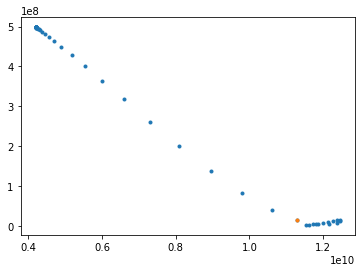

In [642]:
plt.plot(errors,smoothings,'.')
plt.plot(errors[13],smoothings[13],'.')

In [682]:
x = np.zeros((3*len(UA),1))
x_aug = np.vstack((x,PA.reshape(6,1)))
x_aug, energy = Kalman_filter_aug(A, A_aug, H_aug, x_aug, data, 0, 1*sigma_r, 0*sigma_q, 0.4, T)

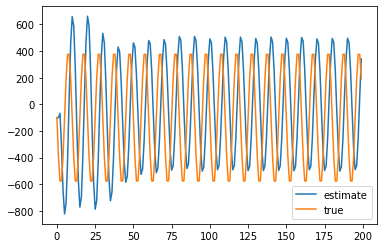

In [683]:
plt.plot(x_aug[19,:200], label='estimate')
plt.plot(f[1,:200], label='true')
plt.legend()

In [444]:
errors = []
smoothings = []
sigma_fs = []
for sigma_f in tqdm(np.logspace(-5,1)):
    x = np.zeros((3*len(UA),1))
    x_aug = np.vstack((x,PA.reshape(6,1)))
    x_aug, energy = Kalman_filter_aug(A, A_aug, H_aug, x_aug, data, 0, 1*sigma_r, 0*sigma_q, sigma_f, T)
    error = np.linalg.norm(data-H_aug@x_aug)**2
    smoothing = np.linalg.norm(x_aug[18:23,:])**2
    errors.append(error)
    smoothings.append(smoothing)
    sigma_fs.append(sigma_f)

100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


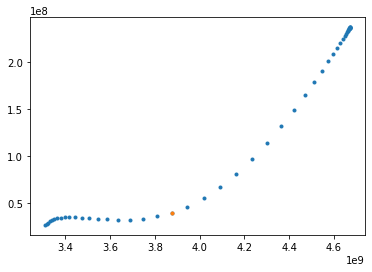

In [446]:
plt.plot(errors,smoothings,'.')
plt.plot(errors[30],smoothings[30],'.')

In [437]:
errors_and_smoothings = []
for i in range(len(errors)):
    errors_and_smoothings.append(errors[i]+smoothings[i])
index = np.argmin(errors_and_smoothings)
sigma_f_opt = sigma_fs[index]
print(sigma_f_opt)

54.286754393238596


In [447]:
x = np.zeros((3*len(UA),1))
x_aug = np.vstack((x,PA.reshape(6,1)))
x_aug, energy = Kalman_filter_aug(A, A_aug, H_aug, x_aug, data, 0, 1*sigma_r, 0*sigma_q, sigma_fs[30], T)

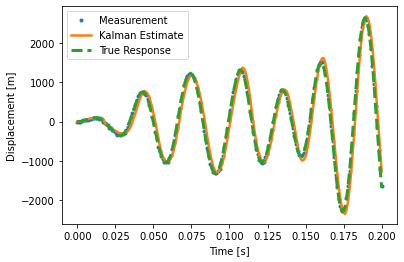

In [448]:
scale = 0.2
index = -1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[0,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x_aug[12,:int(T*scale)], label='Kalman Estimate', linewidth=2.5)
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a_ddot[0,:int(T*scale)], '--', label='True Response', linewidth=3.0)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

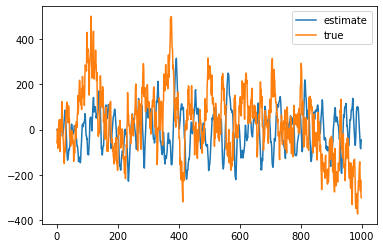

In [455]:
plt.plot(x_aug[23,:], label='estimate')
plt.plot(f[5,:], label='true')
plt.legend()

In [572]:
def Kalman_filter_2stages(A, B, H, J, x, f, y, sigma_x, sigma_f, sigma_r, sigma_q_x, sigma_q_f, T):
  Q_x = sigma_q_x*np.identity(np.shape(A)[1])
  Q_f = sigma_q_f*np.identity(np.shape(B)[1])
  R = sigma_r*np.identity(np.shape(y)[0])
  
  P = [sigma_x*np.identity(np.shape(A)[1])]
  P_f = [sigma_f*np.identity(np.shape(B)[1])]

  energy = 0

  for i in range(1,T):
    f_predict = f[:,i-1]
    P_f_predict = P_f[i-1] + Q_f
    V_f = y[:,i] - np.dot(H, x[:,i-1]) - np.dot(J, f_predict)
    S_f = np.dot(J, np.dot(P_f_predict, np.transpose(J))) + R
    K_f = np.dot(P_f_predict, np.dot(np.transpose(J), np.linalg.inv(S_f)))
    f_estimate = f_predict + np.dot(K_f, V_f)
    P_f_estimate = P_f_predict - np.dot(K_f, np.dot(J, P_f_predict))
    x_predict = np.dot(A, x[:,i-1]) + np.dot(B, f_estimate)
    P_predict = np.dot(A, np.dot(P[i-1], np.transpose(A))) + Q_x
    V = y[:,i] - np.dot(H, x_predict) - np.dot(J, f_estimate)
    S = np.dot(H, np.dot(P_predict, np.transpose(H))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(H, P_predict))

    x = np.append(x, x_estimate.reshape(np.shape(A)[1],1), axis=1)
    P.append(P_estimate)
    f = np.append(f, f_estimate.reshape(np.shape(B)[1],1), axis=1)
    P_f.append(P_f_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, f, energy

In [599]:
J = np.zeros((7,6))
J[6,1] = 1

In [600]:
x = np.zeros((3*len(UA),1))
f = np.reshape(wind_force([0.05,4.3],T)[:,0], (6,1))
x, f, energy = Kalman_filter_2stages(A, B, np.vstack((H,np.zeros((1,18)))), J, x, f, np.vstack((data,generate_pseudo_data(wind_force([0.05, 4.3], 1000),T,0.1)[1,:])), 10**(-20), 10**(-20), 1*sigma_r, 10**(-10)*sigma_q, np.logspace(-2,10)[43], T)

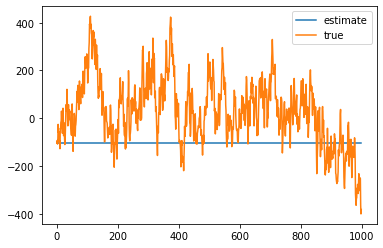

In [603]:
plt.plot(f[3,:], label='estimate')
plt.plot(wind_force([0.05, 4.3], 1000)[3,:], label='true')
plt.legend()

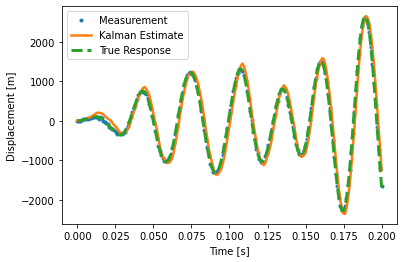

In [571]:
scale = 0.2
index = -1
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), data[0,:int(T*scale)], '.', label='Measurement')
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), x_aug[12,:int(T*scale)], label='Kalman Estimate', linewidth=2.5)
plt.plot(np.linspace(0, T*deltaT*scale, int(T*scale)), a_ddot[0,:int(T*scale)], '--', label='True Response', linewidth=3.0)
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

plt.legend()
plt.show()

In [550]:
errors = []
smoothings = []
sigma_fs = []
for sigma_q_f in tqdm(np.logspace(-2,10)):
    x = np.zeros((3*len(UA),1))
    f = np.reshape(wind_force([0.05,4.3],T)[:,0], (6,1))
    x, f, energy = Kalman_filter_2stages(A, B, np.vstack((H,np.zeros((1,18)))), J, x, f, np.vstack((data,wind_force([0.05, 4.3], 1000)[1,:])), 10**(-20), 10**(-20), 1*sigma_r, 10**(-20)*sigma_q, sigma_q_f, T)
    error = np.linalg.norm(np.vstack((data,generate_pseudo_data(wind_force([0.05, 4.3], 1000),T,0.01)[1,:]))-np.vstack((H,np.zeros((1,18))))@x-J@f)**2
    smoothing = sigma_q_f**2
    errors.append(error)
    smoothings.append(smoothing)
    sigma_fs.append(sigma_f)

100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


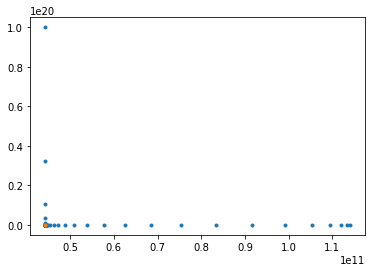

In [551]:
plt.plot(errors,smoothings,'.')
plt.plot(errors[43],smoothings[43],'.')

In [604]:
J = 10**(-5)*np.identity(6)
x = np.zeros((3*len(UA),1))
f = np.reshape(wind_force([0.05,4.3],T)[:,0], (6,1))
x, f, energy = Kalman_filter_2stages(A, B, H, J, x, f, data, 10**(-20), 10**(-20), 1*sigma_r, 10**(-10)*sigma_q, 1, T)

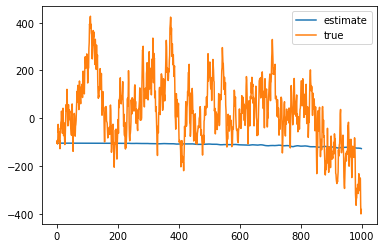

In [606]:
plt.plot(f[3,:], label='estimate')
plt.plot(wind_force([0.05, 4.3], 1000)[3,:], label='true')
plt.legend()

In [596]:
errors = []
smoothings = []
sigma_fs = []
for sigma_q_f in tqdm(np.logspace(-2,10)):
    x = np.zeros((3*len(UA),1))
    f = np.reshape(wind_force([0.05,4.3],T)[:,0], (6,1))
    x, f, energy = Kalman_filter_2stages(A, B, H, J, x, f, data, 10**(-20), 10**(-20), 1*sigma_r, 10**(-10)*sigma_q, sigma_q_f, T)
    error = np.linalg.norm(data-H@x-J@f)**2
    smoothing = sigma_q_f**2
    errors.append(error)
    smoothings.append(smoothing)
    sigma_fs.append(sigma_f)

100%|██████████| 50/50 [00:24<00:00,  2.01it/s]


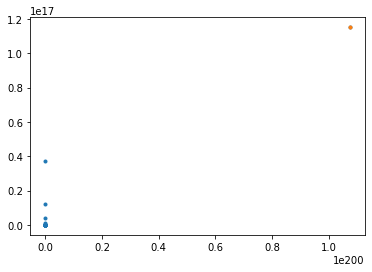

In [597]:
plt.plot(errors,smoothings,'.')
plt.plot(errors[43],smoothings[43],'.')

In [78]:
def Kalman_filter(A, B, H, x, f, y, sigma_0, sigma_r, sigma_q, T):
  Q = sigma_q*np.identity(np.shape(A)[0])
  R = sigma_r*np.identity(np.shape(y)[0])
  
  P = [sigma_0*np.identity(np.shape(A)[0])]

  energy = 0

  for i in range(T-1):
    x_predict = np.dot(A, x[:,i]) + np.dot(B, f[:,i+1])
    P_predict = np.dot(A, np.dot(P[i], np.transpose(A))) + Q
    V = y[:,i] - np.dot(H, x_predict)
    S = np.dot(H, np.dot(P_predict, np.transpose(H))) + R
    K = np.dot(P_predict, np.dot(np.transpose(H), np.linalg.inv(S)))
    x_estimate = x_predict + np.dot(K, V)
    P_estimate = P_predict - np.dot(K, np.dot(S, np.transpose(K)))

    x = np.append(x, x_estimate.reshape(np.shape(A)[0],1), axis=1)
    P.append(P_estimate)
   
    energy += 0.5*np.log(np.linalg.det(2*np.pi*S))+0.5*np.dot(np.transpose(V), np.dot(np.linalg.inv(S), V))

  return x, energy

In [217]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, wind_force, data, 1, sigma_r, 1*sigma_q, [0, 2], [[0.01, 0], [0, 1]], 0.2, T, 1000, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)

100%|██████████| 999/999 [02:23<00:00,  6.95it/s]


[-0.00690268  1.95245295]
0.916


In [218]:
x = []
y = []
for i in range(len(param)):
    x.append(param[i][0])
    y.append(param[i][1])

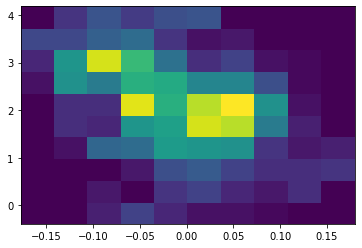

In [219]:
plt.hist2d(x, y)
plt.show()

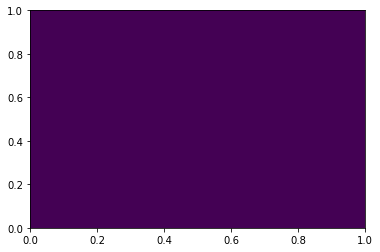

In [207]:
plt.hist2d(x[100::10], y[100::10])
plt.show()

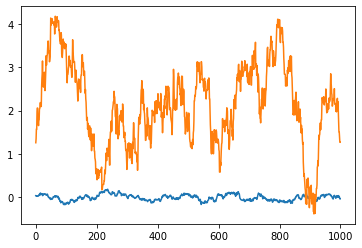

In [220]:
plt.plot(param)

In [285]:
x = np.zeros((3*len(UA),1))
x[0:6,0] = np.transpose(UA)
param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, wind_force, data, 1, sigma_r, 0*sigma_q, [0, 0], [[0.001, 0], [0, 1]], 0.2, T, 1000, 'grw')
index = np.argmin(energy_list)
mean_MAP = param[index]
print(mean_MAP)
print(acc)

100%|██████████| 999/999 [02:17<00:00,  7.26it/s]

[-0.00606957  5.53423797]
0.037


In [286]:
x = []
y = []
for i in range(len(param)):
    x.append(param[i][0])
    y.append(param[i][1])

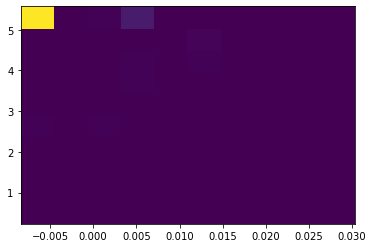

In [287]:
plt.hist2d(x, y)
plt.show()

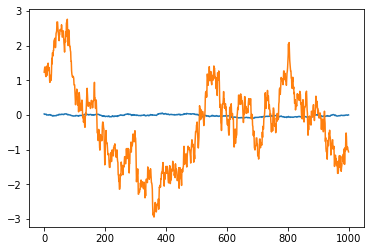

In [284]:
plt.plot(param)

In [304]:
factors = np.linspace(0,1,20)
MAP = []
for factor in factors:
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, wind_force, data, 1, sigma_r, factor*sigma_q, [0, 0], [[0.001, 0], [0, 1]], 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:13<00:00,  7.08it/s]


In [305]:
for i in range(len(MAP)):
    MAP[i][0] = MAP[i][0]/0.05
    MAP[i][1] = MAP[i][1]/4.3

In [306]:
MAP_1 = []
MAP_2 = []
for i in range(len(MAP)):
    MAP_1.append(MAP[i][0])
    MAP_2.append(MAP[i][1])

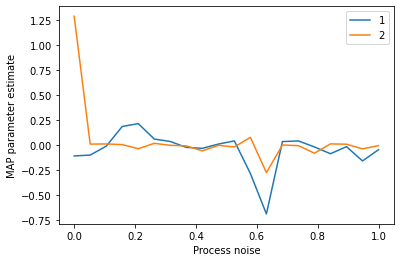

In [307]:
plt.plot(factors, MAP_1, label="1")
plt.plot(factors, MAP_2, label="2")
plt.xlabel("Process noise")
plt.ylabel("MAP parameter estimate")
plt.legend()

In [308]:
SNR = np.linspace(10, 100, 20)
MAP = []
for i in range(len(SNR)):
    data = generate_pseudo_data(a_ddot, T, 1/SNR[i])
    sigma_r = 1/SNR[i]*np.std(a_ddot)
    sigma_q = np.mean(np.abs(a_ddot))
    x = np.zeros((3*len(UA),1))
    x[0:6,0] = np.transpose(UA)
    param, energy_list, X, acc = Metropolis_Hastings(A, B, H, x, wind_force, data, 1, sigma_r, 0*sigma_q, [0, 0], [[0.001, 0], [0, 0.1]], 0.2, T, 100, 'grw')
    index = np.argmin(energy_list)
    mean_MAP = param[index]
    MAP.append(mean_MAP)

100%|██████████| 99/99 [00:14<00:00,  6.81it/s]


In [309]:
for i in range(len(MAP)):
    MAP[i][0] = MAP[i][0]/0.05
    MAP[i][1] = MAP[i][1]/4.3

In [310]:
MAP_1 = []
MAP_2 = []
for i in range(len(MAP)):
    MAP_1.append(MAP[i][0])
    MAP_2.append(MAP[i][1])

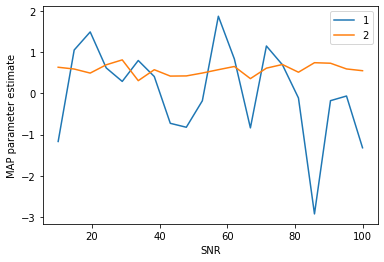

In [311]:
plt.plot(SNR, MAP_1, label="1")
plt.plot(SNR, MAP_2, label="2")
plt.xlabel("SNR")
plt.ylabel("MAP parameter estimate")
plt.legend()